In [2]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing
from msresist.clustering import MassSpecClustering

In [28]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

# Fit DDMC
ddmc = MassSpecClustering(i, ncl=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
centers = ddmc.transform()

In [9]:
X["Cluster"] = ddmc.labels()

In [25]:
centers = pd.DataFrame(ddmc.transform()).T
centers.columns = X.columns[7:-1]
centers["Cluster"] = [1, 2, 3, 4, 5]
m = pd.melt(centers, id_vars=["Cluster"], value_vars=list(centers.columns), value_name="p-signal", var_name="Lines")
m["p-signal"] = m["p-signal"].astype("float64")

<AxesSubplot:xlabel='Lines', ylabel='p-signal'>

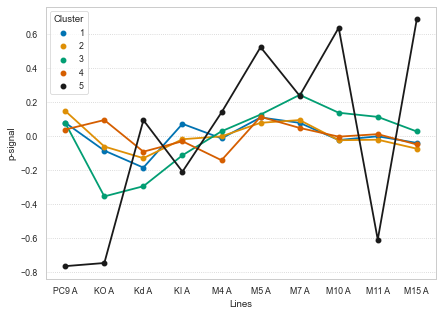

In [69]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.set_context("paper", rc={'lines.linewidth': 1}) 
palette ={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "k"}
sns.pointplot(x="Lines", y="p-signal", data=m, hue="Cluster", ax=ax, palette=palette, dashes=False, **{"linewidth": 0})

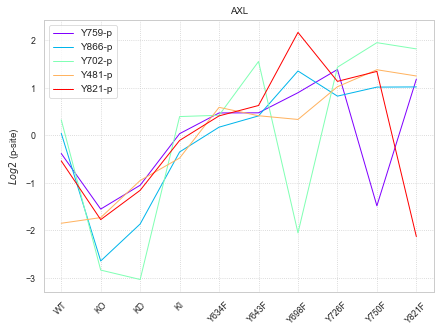

In [130]:
from msresist.figures.figure1 import plot_AllSites
_, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_AllSites(ax, X, "AXL", "AXL", ylim=False)
ax.legend(prop={'size':10})

In [159]:
lines = ["WT", "KO", "KD", "KI", "634", "643", "698", "726", "750", "821"]
def kinase_heatmap(X, prot_dict, ax, FC=False):
    """ Make a heatmap out of a dictionary wih p-sites """
    out = []
    for p, s in prot_dict:
        out.append(X.set_index(["Gene", "Position"]).loc[p, s])
    out = pd.concat(out).select_dtypes(include=[float])
    if FC:
        for ii in range(out.shape[1]):
            out.iloc[:, ii] /= out.iloc[:, 0]
    sns.heatmap(out, cmap="bwr", ax=ax)
    ax.set_xticklabels(lines)
    ax.set_xlabel("AXL Y—>F mutants")
    ax.set_ylabel("")

/tmp/ipykernel_3988182/4056157975.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  out.append(X.set_index(["Gene", "Position"]).loc[p, s])


Text(0.5, 1.0, 'Receptor Tyrosine Kinases')

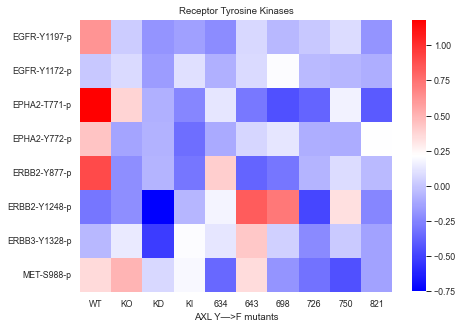

In [162]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
kinase_heatmap(X, [("EGFR", "Y1197-p"),
            ("EGFR", "Y1172-p"),
            ("EPHA2", "T771-p"),
            ("EPHA2", "Y772-p"),
            ("ERBB2", "Y877-p"),
            ("ERBB2", "Y1248-p"),
            ("ERBB3", "Y1328-p"),
            ("MET", "S988-p")], ax=ax, FC=False)
ax.set_title("Receptor Tyrosine Kinases")

/tmp/ipykernel_3988182/4056157975.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  out.append(X.set_index(["Gene", "Position"]).loc[p, s])


Text(0.5, 1.0, 'RTK adapters')

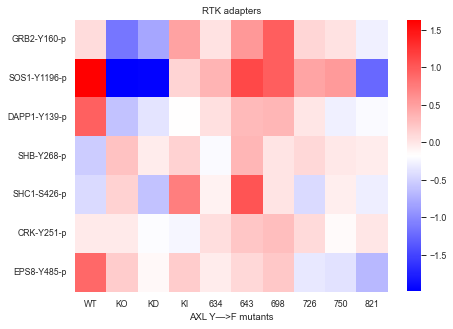

In [228]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
kinase_heatmap(X, [("GRB2", "Y160-p"),
            ("SOS1", "Y1196-p"),
            ("DAPP1", "Y139-p"),
            ("SHB", "Y268-p"),
            ("SHC1", "S426-p"),
            ("CRK", "Y251-p"),
            ("EPS8", "Y485-p")], ax=ax, FC=False)
ax.set_title("RTK adapters")

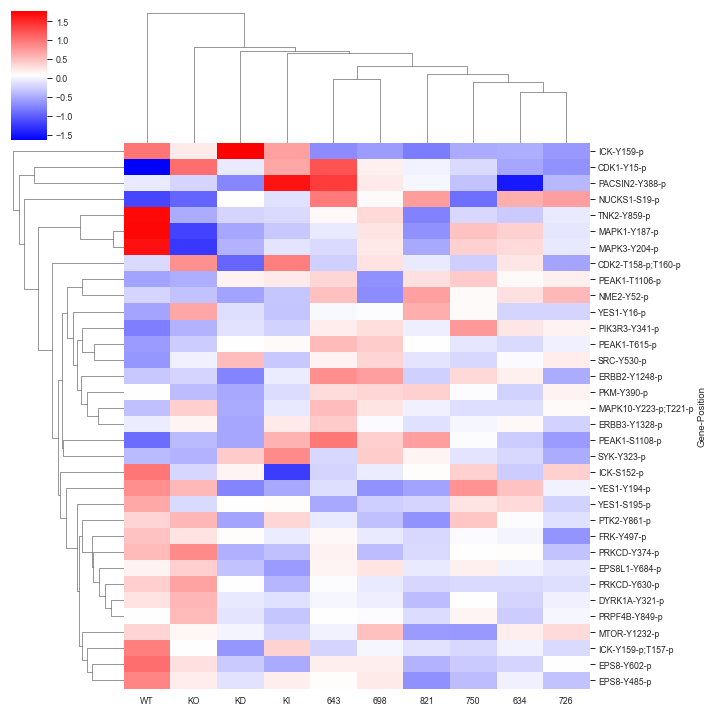

In [229]:
k = X[X["Protein"].str.contains("kinase")]
XIDX = np.any(k.iloc[:, 8:-1] <= -0.5, axis=1) | np.any(k.iloc[:, 8:-1] >= 0.5, axis=1)
k = k.iloc[list(XIDX), :].set_index(["Gene", "Position"]).select_dtypes(include=[float])
k = k.drop("AXL")
sns.clustermap(k, cmap="bwr", xticklabels=lines)

In [528]:
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel, f_oneway
from statsmodels.stats.multitest import multipletests
from bioinfokit import visuz

In [600]:
axl_in = X[["PC9 A", "KI A"]].values
axl_out = X[["KO A", "Kd A"]].values

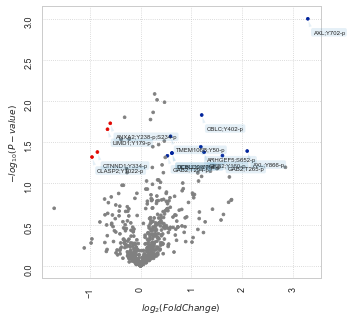

In [602]:
pvals = f_oneway(axl_in, axl_out, axis=1)[1]
# pvals = multipletests(pvals)[1]
fc = axl_in.mean(axis=1) - axl_out.mean(axis=1)
pv = pd.DataFrame()
pv["Peptide"] = [g + ";" + p for g, p in list(zip(X["Gene"], X["Position"]))]
pv["logFC"] = fc
pv["p-values"] = pvals
pv = pv.sort_values(by="p-values")
visuz.GeneExpression.volcano(df=pv, lfc='logFC', pv='p-values', show=True, geneid="Peptide", lfc_thr=(0.5, 0.5), genenames="deg", color=("#00239CFF", "grey", "#E10600FF"), figtype="svg",  gstyle=2, axtickfontname='Arial')

In [603]:
pv.sort_values(by="p-values", ascending=True)[:30]

,Peptide,logFC,p-values
472,AXL;Y702-p,3.296031,0.001008
73,BCAR1;Y372-p,0.277989,0.008217
303,PIK3R2;Y460-p;S457-p,0.326266,0.009675
421,TOM1L2;Y404-p;T401-p,0.472750,0.010352
8,RPLP0;Y24-p,0.248675,0.013738
135,CBLC;Y402-p,1.205324,0.014790
99,CGN;Y99-p,-0.313328,0.015757
20,AFAP1L2;Y54-p,0.196687,0.016786
49,ANXA2;Y238-p;S234-p,-0.596102,0.018629
256,LIMD1;Y179-p,-0.650615,0.022010


In [604]:
pv[pv["Peptide"].str.contains("AXL")]

,Peptide,logFC,p-values
472,AXL;Y702-p,3.296031,0.001008
471,AXL;Y866-p,2.101840,0.040440
470,AXL;Y759-p,1.127689,0.074559
474,AXL;Y821-p,1.142822,0.093472
473,AXL;Y481-p,0.177166,0.843303
